## Adding TPU Support

In [2]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## Dataset Utility Functions

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageSequence

DATA_PATH = '/kaggle/input/medical-image-processing-2d-segmentation/'
OUT_PATH = '/kaggle/working/'

def load_from_multi_page_tiff(path_to_image):
    image_np_array_list = []
    image_with_multi_page = Image.open(path_to_image)
    for idx, page_image in enumerate(ImageSequence.Iterator(image_with_multi_page)):
        image_np_array_list.append(np.array(page_image))
    return np.stack(image_np_array_list)

def load_from_single_page_tiff(path_to_image):
    return np.array(Image.open(path_to_image))

def get_image_shape(np_array):
    if isinstance(np_array, (np.ndarray, np.generic)):
        print("Loaded data shape: {}".format(np_array.shape))
    else:
        print('Input type error!')

def seek_file_in_folder(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

def parsing_cell_tracking_data(ground_truth_path):
    x_image_array, y_image_array = [], []
    for folder in ground_truth_path:
        image_name_list = seek_file_in_folder(DATA_PATH + folder + '/SEG/')
        seg_image_dict = dict()
        for image_name in image_name_list:
            name = image_name[-7:]
            if '.txt' in name : continue
            seg_image_dict[name] = load_from_single_page_tiff(image_name)
        image_name_list_1 = seek_file_in_folder(DATA_PATH + folder[:-3])
        x_image, y_image = [], []
        for img_name, img_array in seg_image_dict.items():
            matching = [s for s in image_name_list_1 if img_name in s]
            x = load_from_single_page_tiff(matching[0])
            x = cv2.resize(x, dsize = (512, 512))
            y = cv2.resize(img_array, dsize = (512, 512))
            x_image.append(x)
            y_image.append(y)
        x_image_array += x_image
        y_image_array += y_image
    return np.stack(x_image_array), np.stack(y_image_array)

def overlap_tile_processing(img_array, expend_px_width, expend_px_height):
    def flip_horizontally(np_array):
        return cv2.flip(np_array, 1)

    def flip_vertically(np_array):
        return cv2.flip(np_array, 0)

    original_height = img_array.shape[0]
    original_width = img_array.shape[1]

    # Expand width first
    # left:
    left_result = flip_horizontally(img_array[0:0 + original_height, 0:0 + expend_px_width])
    # right:
    right_result = flip_horizontally(
        img_array[0:0 + original_height, original_width - expend_px_width: original_width])

    result_img = cv2.hconcat([left_result, img_array])
    result_img = cv2.hconcat([result_img, right_result])

    result_img_height = result_img.shape[0]
    result_img_width = result_img.shape[1]

    # Expand height
    top_result = flip_vertically(result_img[0:0 + expend_px_height, 0:0 + result_img_width])
    bottom_result = flip_vertically(
        result_img[result_img_height - expend_px_height: result_img_height, 0:0 + result_img_width])

    result_img = cv2.vconcat([top_result, result_img])
    result_img = cv2.vconcat([result_img, bottom_result])

    return result_img

def convert_to_datagen_format(py_list):
    nparray = np.array(py_list)
    return nparray.reshape(nparray.shape + (1,))

def data_generator(x, batch_size=10, epoch=50, seed=2003):
    data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=30,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')
    datagen = ImageDataGenerator(**data_gen_args)
    datagen_generator = datagen.flow(x, batch_size=batch_size, seed=seed)
    tmp_x, i = list(), 0
    for batch_x in datagen_generator:
        tmp_x += list(batch_x)
        i += 1
        if i >= epoch: 
            return np.array(tmp_x)

def split_image2_4patch(imgs):
    ret = list()
    for x in imgs:
        ret.append(x[0:572, 0:572, :].copy())
        ret.append(x[0:572, 124:696, :].copy())
        ret.append(x[124:696, 0:572, :].copy())
        ret.append(x[124:696, 124:696, :].copy())
    return np.array(ret)

## Dataset Loading Functions
All images have been resized to 512x512

In [4]:
def get_ISBI_2012_dataset():
    """
    Loading from ISBI dataset and convert to two image array (raw_data & ground_truth)
    :return: np_array, np_array
    """
    x_image_array = load_from_multi_page_tiff(path_to_image=DATA_PATH + 'ISBI2012/train-volume.tif')
    y_image_array = load_from_multi_page_tiff(path_to_image=DATA_PATH + 'ISBI2012/train-labels.tif')
    get_image_shape(x_image_array)
    x = np.array(x_image_array, dtype = np.float32) / 255
    y = np.array(y_image_array, dtype = np.float32) / 255
    return x, y

def get_DIC_C2DH_HeLa():
    """
    get DIC C2DH HeLa dataset where had ground truth data only
    :return: x_np_array, y_np_array
    """
    folder_path_list = ['PhC-C2DH-U373/01_GT', 'PhC-C2DH-U373/02_GT']
    x, y = parsing_cell_tracking_data(folder_path_list)
    get_image_shape(x)
    y[y > 0] = 255
    x = np.array(x, dtype = np.float32) / 255
    y = np.array(y, dtype = np.float32) / 255
    return x, y

def get_PhC_C2DH_U373():
    """
    get PhC C2DH U373 dataset where had ground truth data only
    :return: x_np_array, y_np_array
    """
    folder_path_list = ['DIC-C2DH-HeLa/01_GT', 'DIC-C2DH-HeLa/02_GT']
    x, y = parsing_cell_tracking_data(folder_path_list)
    get_image_shape(x)
    y[y > 0] = 255
    x = np.array(x, dtype = np.float32) / 255
    y = np.array(y, dtype = np.float32) / 255
    return x, y

## Weight map generator

In [5]:
# weight maps for binary masks
import scipy.ndimage as ndi
def weight_map(img, w0=10, sigma=5):
    """
    Create a UNet weight map from a boolean `mask` where `True`
    marks the interior pixels of an instance.
    """
    mask = np.array(img, dtype=np.int32)
    # if the mask only has one contiguous class,
    # then there isn't much to do.
    if len(np.unique(mask)) == 1:
        return np.ones(mask.shape, dtype=np.float32) * 0.5

    # calculate the class-balanced weight map w_c
    w_c = np.zeros(mask.shape, dtype=np.float32)
    w_1 = 1 - float(np.count_nonzero(mask)) / w_c.size
    w_0 = 1 - w_1
    w_c[mask > 0.5] = w_1
    w_c[mask < 0.5] = w_0

    # calculate the distance-weighted emphases w_e
    segs, _ = ndi.label(mask)
    if segs.max() == 1:
        # if there is only 1 instance plus background,
        # then there are no separations
        return w_c
    ilabels = range(1, segs.max()+1)
    distmaps = np.stack([ndi.distance_transform_edt(segs != l) for l in ilabels])
    distmaps = np.sort(distmaps, axis=0)[:2]
    w_e = w0 * np.exp((-1 * (distmaps[0] + distmaps[1]) ** 2) / (2 * (sigma ** 2)))
    w_e[mask] = 0.
    return w_c + w_e

def get_weight_maps(data):
    weight_maps = []
    m = data.shape[0]
    print('Generating weight maps...')
    for i, img in enumerate(data):
        cur = weight_map(img)
        weight_maps.append(cur)
        if (i + 1) % 15 == 0 : 
            print(i + 1)
        elif (i + 1) == m:
            print(i + 1)
        else : 
            print(i + 1, end=' ')
    return weight_maps

## Visualise function

In [6]:
def visualize_pred(x, y_true, y_pred, title1="Original", title2="True", title3="Predicted", cmap='gray'):
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    ax = plt.subplot("131")
    ax.set_title(title1)
    ax.imshow(np.squeeze(x), cmap=cmap)

    ax = plt.subplot("132")
    ax.set_title(title2)
    ax.imshow(np.squeeze(y_true), cmap=cmap)
    
    ax = plt.subplot("133")
    ax.set_title(title3)
    ax.imshow(np.squeeze(y_pred), cmap=cmap)
    
    ctr = 1
    file = 'plots_' + str(ctr) + '.png'
    while os.path.isfile(file):
        ctr += 1
        file = 'plots_' + str(ctr) + '.png'
    plt.savefig(file, bbox_inches='tight')
    
    plt.show()

## Data Loading

In [7]:
# DATA for everything
from glob import glob
cur = 'ISBI'

def name(s):
    return OUT_PATH + str(s) + '_' + cur + '.npy'

def get_data():
    if cur == 'ISBI' : return get_ISBI_2012_dataset()
    if cur == 'HeLa' : return get_DIC_C2DH_HeLa()
    if cur == 'U373' : return get_PhC_C2DH_U373()
    print('Wrong name specified')

print('Deleting old files...')
for file in glob('*.npy'):
    os.remove(file)

print('Loading {} dataset...'.format(cur))
X_0, Y_0 = get_data()
W_0 = get_weight_maps(Y_0)

X_1 = convert_to_datagen_format(X_0)
Y_1 = convert_to_datagen_format(Y_0)
W_1 = convert_to_datagen_format(W_0)

print('Augmenting data...')
X = data_generator(X_1, batch_size=10, epoch=25, seed=2003) 
Y = data_generator(Y_1, batch_size=10, epoch=25, seed=2003) 
W = data_generator(W_1, batch_size=10, epoch=25, seed=2003) 
print('Shape : {}'.format(X.shape))

# print('Saving data...')
# np.save(name('X'), X)
# np.save(name('Y'), Y)
# np.save(name('W'), W)
# print("Saved successfully")

Deleting old files...
Loading ISBI dataset...
Loaded data shape: (30, 512, 512)
Generating weight maps...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Augmenting data...
Shape : (250, 512, 512, 1)


In [8]:
# only for uNet1
def uNet1_preprocess(x, y, w):
    X_1, Y_1, W_1 = list(), list(), list()
    for i in range(x.shape[0]):
        X_1.append(overlap_tile_processing(x[i, :, :, 0], 92, 92))
        Y_1.append(overlap_tile_processing(y[i, :, :, 0], 92, 92))
        W_1.append(overlap_tile_processing(w[i, :, :, 0], 92, 92))
    
    X_1 = convert_to_datagen_format(X_1)
    Y_1 = convert_to_datagen_format(Y_1)
    W_1 = convert_to_datagen_format(W_1)
    
    X_2 = split_image2_4patch(X_1)
    Y_2 = split_image2_4patch(Y_1)
    W_2 = split_image2_4patch(W_1)
    
    Y_2 = Y_2[:, 92:-92, 92:-92, :]
    W_2 = W_2[:, 92:-92, 92:-92, :]
    print('X shape : {}'.format(X_2.shape))
    print('Y shape : {}'.format(Y_2.shape))
    return X_2, Y_2, W_2

X, Y, W = uNet1_preprocess(X, Y, W)

X shape : (1000, 572, 572, 1)
Y shape : (1000, 388, 388, 1)


## Data Visualization

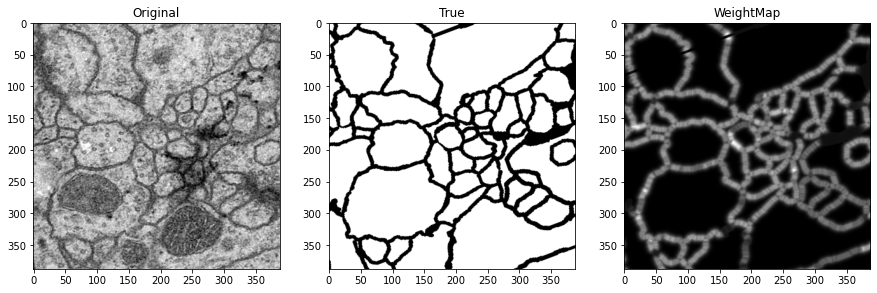

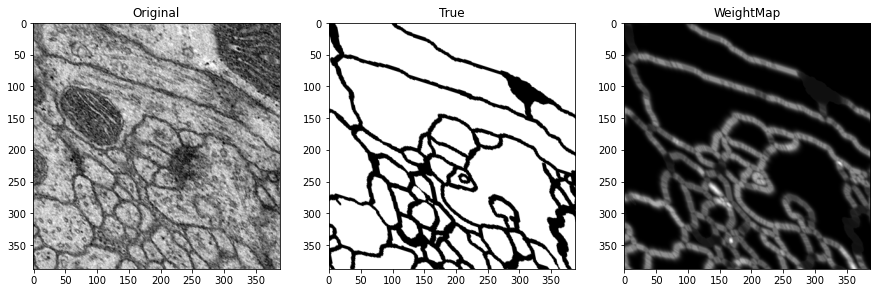

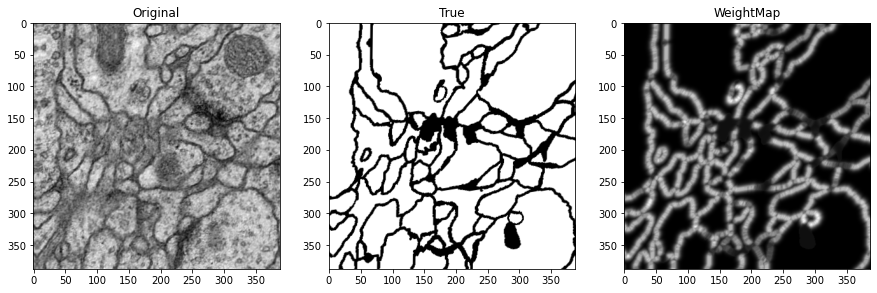

In [9]:
ids = np.random.randint(0, X.shape[0], size = 3)
for index in ids:
    xx, yy, ww = X[index], Y[index], W[index]
    visualize_pred(xx[92:-92, 92:-92, :], yy, ww, title1="Original", title2="True", title3="WeightMap")    

## Train Test Split

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(X, Y, W, test_size=0.1)
X_val, X_test, Y_val, Y_test, W_val, W_test = train_test_split(X_val, Y_val, W_val, test_size=0.5)
print('Train: X = {} Y = {}'.format(X_train.shape, Y_train.shape))
print('Val: X = {} Y = {}'.format(X_val.shape, Y_val.shape))
print('Test: X = {} Y = {}'.format(X_test.shape, Y_test.shape))

Train: X = (900, 572, 572, 1) Y = (900, 388, 388, 1)
Val: X = (50, 572, 572, 1) Y = (50, 388, 388, 1)
Test: X = (50, 572, 572, 1) Y = (50, 388, 388, 1)


## Model Architectures

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Cropping2D, Conv2D, Conv2DTranspose, MaxPooling2D, Softmax
from tensorflow.keras.layers import Input, Add, Multiply, Lambda, Concatenate, Dropout
import tensorflow.keras.backend as K

# loss will be binary_crossentropy
def uNet1():
    concat_axis = 3
    k_init = 'he_normal'
    with strategy.scope():
        inputs = Input((572, 572, 1), name='image_input')
        conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(inputs)
        conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(conv1_1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_2)

        conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(pool1)
        conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(conv2_1)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)

        conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(pool2)
        conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(conv3_1)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_2)

        conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(pool3)
        conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(conv4_1)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_2)

        conv5_1 = Conv2D(1024, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(pool4)
        conv5_2 = Conv2D(1024, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(conv5_1)

        upsampling1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='valid', kernel_initializer=k_init)(conv5_2)
        crop_conv4_2 = Cropping2D(cropping=((4, 4), (4, 4)))(conv4_2)
        up6 = Concatenate(axis=concat_axis)([upsampling1, crop_conv4_2])
        conv6_1 = Conv2D(512, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(up6)
        conv6_2 = Conv2D(512, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(conv6_1)

        upsampling2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='valid', kernel_initializer=k_init)(conv6_2)
        crop_conv3_2 = Cropping2D(cropping=((16, 16), (16, 16)))(conv3_2)
        up7 = Concatenate(axis=concat_axis)([upsampling2, crop_conv3_2])
        conv7_1 = Conv2D(256, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(up7)
        conv7_2 = Conv2D(256, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(conv7_1)

        upsampling3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='valid', kernel_initializer=k_init)(conv7_2)
        crop_conv2_2 = Cropping2D(cropping=((40, 40), (40, 40)))(conv2_2)
        up8 = Concatenate(axis=concat_axis)([upsampling3, crop_conv2_2])
        conv8_1 = Conv2D(128, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(up8)
        conv8_2 = Conv2D(128, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(conv8_1)

        upsampling4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='valid', kernel_initializer=k_init)(conv8_2)
        crop_conv1_2 = Cropping2D(cropping=((88, 88), (88, 88)))(conv1_2)
        up9 = Concatenate(axis=concat_axis)([upsampling4, crop_conv1_2])
        conv9_1 = Conv2D(64, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(up9)
        conv9_2 = Conv2D(64, (3, 3), activation='relu', padding='valid', kernel_initializer=k_init)(conv9_1)

        conv10 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer='glorot_normal', name='seg_output')(conv9_2)

        model = Model(inputs=[inputs], outputs=[conv10])
        return model

## Loss functions

In [12]:
# LOSS functions
def iou(true, pred):
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)
    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * K.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def iou_loss(y_true, y_pred):
    return 1 - iou(y_true, y_pred)

# for weighted_uNet only
def identity_loss(y_true, y_pred):
    return y_pred

In [13]:
K.clear_session()
model = uNet1()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 572, 572, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 570, 570, 64) 640         image_input[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 568, 568, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 284, 284, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Model Training

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
model_name = 'unet1.h5'

# early stopping should always be the last callback
stopper = EarlyStopping(monitor='loss', patience=5)
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_loss', mode='min', save_best_only=True)
model.compile(optimizer = Adam(lr=0.001), loss = 'binary_crossentropy')

losses = list()
val_losses = list()

if os.path.isfile(model_name):
    print('Loaded saved Model!')
    model.load_weights(model_name)

In [21]:
history = model.fit(
    X_train, Y_train,
    batch_size = 10 * strategy.num_replicas_in_sync,
    epochs = 100,
    validation_data = (X_val, Y_val),
    callbacks = [checkpointer, stopper],
    shuffle = True,
    verbose = 1
)

losses += list(history.history['loss'])
val_losses += list(history.history['val_loss'])

Epoch 1/100
12/12 [==============================] - 6s 536ms/step - loss: 0.0807 - val_loss: 0.1760
Epoch 2/100
12/12 [==============================] - 6s 530ms/step - loss: 0.0848 - val_loss: 0.1631
Epoch 3/100
12/12 [==============================] - 6s 528ms/step - loss: 0.0834 - val_loss: 0.1647
Epoch 4/100
12/12 [==============================] - 6s 527ms/step - loss: 0.0803 - val_loss: 0.1716
Epoch 5/100
12/12 [==============================] - 6s 528ms/step - loss: 0.0783 - val_loss: 0.1675
Epoch 6/100
12/12 [==============================] - 6s 530ms/step - loss: 0.0760 - val_loss: 0.1736
Epoch 7/100
12/12 [==============================] - 6s 533ms/step - loss: 0.0755 - val_loss: 0.1762
Epoch 8/100
12/12 [==============================] - 6s 530ms/step - loss: 0.0743 - val_loss: 0.1732
Epoch 9/100
12/12 [==============================] - 6s 533ms/step - loss: 0.0738 - val_loss: 0.1754
Epoch 10/100
12/12 [==============================] - 6s 530ms/step - loss: 0.0742 - val_lo

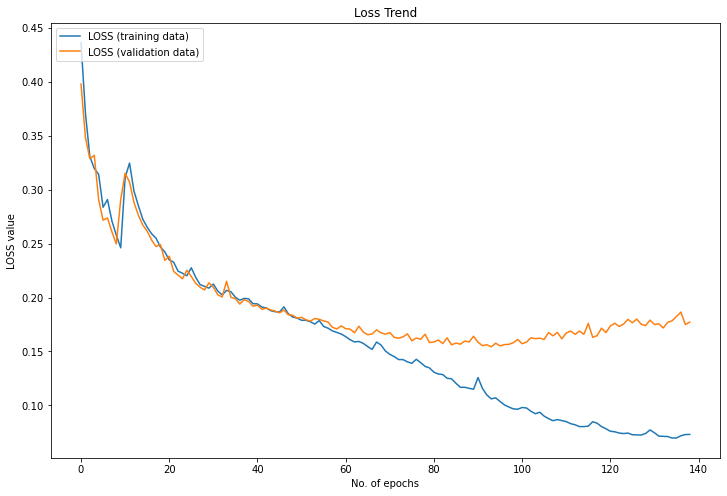

In [24]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)
plt.plot(losses, label='LOSS (training data)')
plt.plot(val_losses, label='LOSS (validation data)')
plt.title('Loss Trend')
plt.ylabel('LOSS value')
plt.xlabel('No. of epochs')
plt.legend(loc="upper left")
plt.savefig('loss_trend.png', bbox_inches='tight')
plt.show()

## Model Predictions

In [25]:
predictor = K.function([model.get_layer('image_input').input], [model.get_layer('seg_output').output])
Y_pred = predictor(X_test)[0]
print('Pred : {}'.format(Y_pred.shape))
print('True : {}'.format(Y_test.shape))
print('Original : {}'.format(X_test.shape))

Pred : (50, 388, 388, 1)
True : (50, 388, 388, 1)
Original : (50, 572, 572, 1)


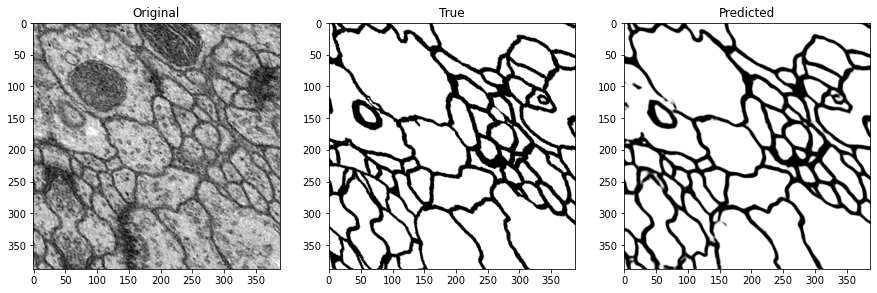

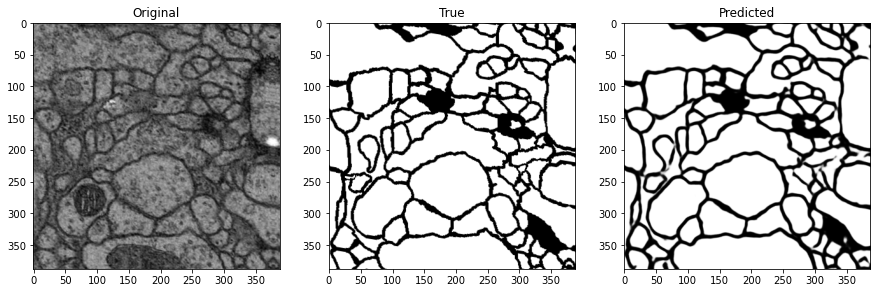

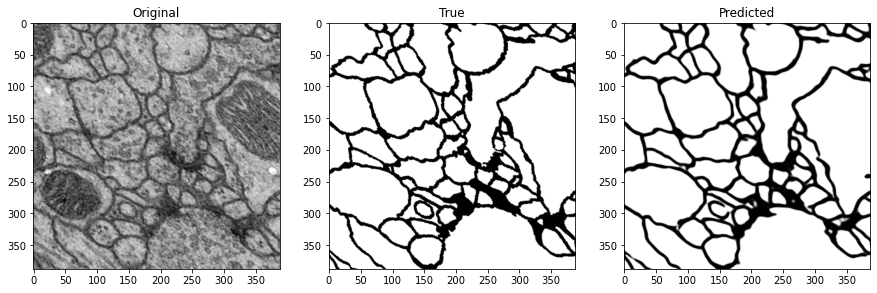

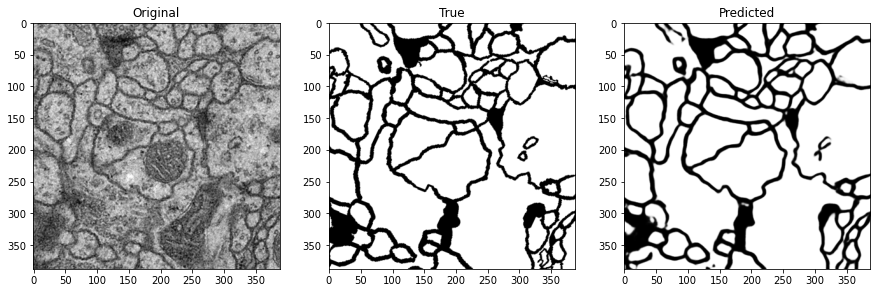

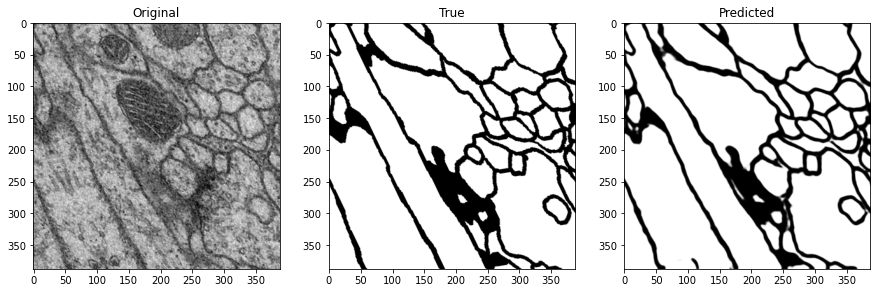

In [26]:
# visualize results
total = X_test.shape[0]
ids = np.random.randint(0, total, size = 5)
for i in ids:
    visualize_pred(X_test[i][92:-92, 92:-92, :], Y_test[i], Y_pred[i])    

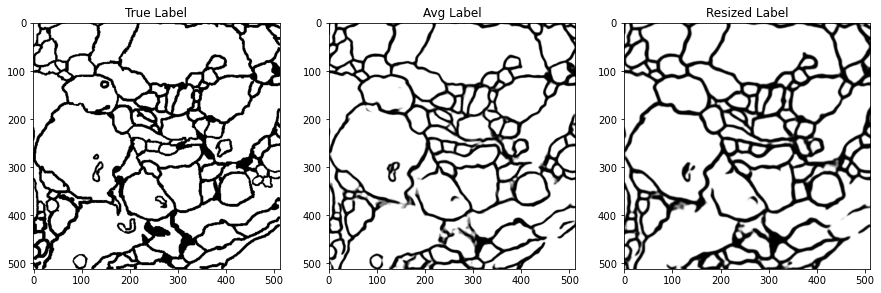

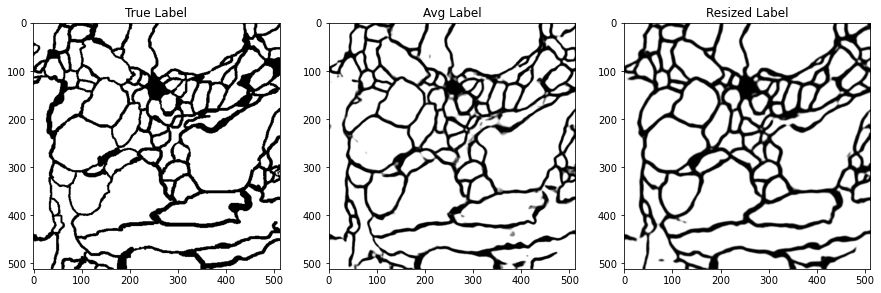

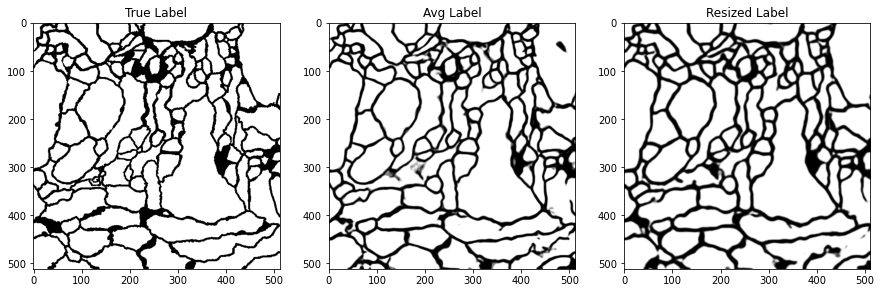

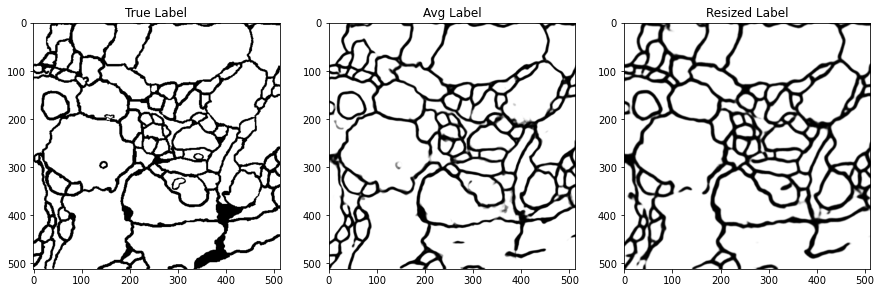

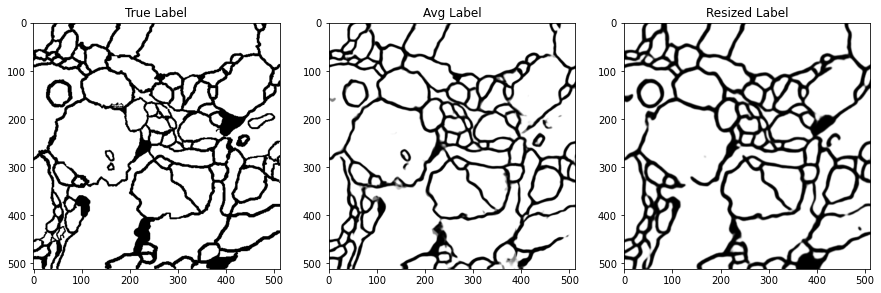

In [27]:
def avg_pred(img):
    assert(img.shape == (512, 512))
    img = overlap_tile_processing(img, 92, 92)
    img = img.reshape((1,) + img.shape + (1,))
    imgs = split_image2_4patch(img)
    y_pred = predictor(imgs)[0]
    ret = np.zeros((512, 512), dtype=np.float32)
    ret[:388, :388] += y_pred[0,:,:,0]
    ret[:388, -388:] += y_pred[1,:,:,0]
    ret[-388:, :388] += y_pred[2,:,:,0]
    ret[-388:, -388:] += y_pred[3,:,:,0]
    ret /= 2
    ret[124:-124, 124:-124] /= 2
    ret[:124, :124] *= 2
    ret[:124, -124:] *= 2
    ret[-124:, :124] *= 2
    ret[-124:, -124:] *= 2
    return ret
    
def resize_pred(img):
    assert(img.shape == (512, 512))
    img = cv2.resize(img, dsize = (388, 388))
    img = overlap_tile_processing(img, 92, 92)
    img = img.reshape((1,) + img.shape + (1,))
    y_pred = predictor(img)[0]
    ret = cv2.resize(y_pred[0, :, :, 0], dsize = (512, 512))
    return ret

total = X_0.shape[0]
ids = np.random.randint(0, total, size = 5)
for i in ids:
    ref = X_0[i]
    out1 = avg_pred(ref)
    out2 = resize_pred(ref)
    out1 = convert_to_datagen_format(out1)
    out2 = convert_to_datagen_format(out2)
    cur = convert_to_datagen_format(Y_0[i])
    visualize_pred(cur, out1, out2, title1="True Label", title2="Avg Label", title3="Resized Label", cmap='gray')

## Metrics

In [28]:
# Metrics
def iou_batch(y_trues_in, y_preds_in):
    y_true = (y_trues_in >= 0.5).squeeze()
    y_pred = (y_preds_in >= 0.5).squeeze()
    unions = np.sum(y_pred | y_true, (1, 2))
    intersections = np.sum(y_pred * y_true, (1, 2))
    ious = np.maximum(0.0, np.ceil(20 * intersections / np.where(unions == 0.0, 1, unions) - 10) / 10)
    return np.mean(np.where(unions == 0, 1, ious))

def pixel_error(y_trues_in, y_preds_in):
    y_true = (y_trues_in >= 0.5).squeeze()
    y_pred = (y_preds_in >= 0.5).squeeze()
    eq = (y_true == y_pred).sum()
    ones = np.ones_like(y_true)
    return 1 - eq / ones.sum()

def dice_batch(y_trues_in, y_preds_in):
    y_true = (y_trues_in >= 0.5).squeeze()
    y_pred = (y_preds_in >= 0.5).squeeze()
    score = 0.0
    for im1, im2 in zip(y_true, y_pred):
        im_sum = im1.sum() + im2.sum()
        if im_sum == 0:
            score += 1.0
            continue
        intersection = np.logical_and(im1, im2)
        score += (2. * intersection.sum() / im_sum)
    return score / y_pred.shape[0]

def rand_error(y_trues_in, y_preds_in):
    y_true = (y_trues_in >= 0.5).squeeze()
    y_pred = (y_preds_in >= 0.5).squeeze()
    rand_index = 0
    for v1, v2 in zip(y_true, y_pred):
        n = v1.shape[0] * v1.shape[1]
        s1 = [n - v1.sum(), v1.sum()]
        s2 = [n - v2.sum(), v2.sum()]
        M = [[0,0], [0,0]]
        M[0][0] = np.logical_and(np.logical_not(v1), np.logical_not(v2)).sum()
        M[0][1] = np.logical_and(np.logical_not(v1), v2).sum()
        M[1][0] = np.logical_and(v1, np.logical_not(v2)).sum()
        M[1][1] = np.logical_and(v1, v2).sum()
        a, b = 0, 0
        for i in range(2):
            for j in range(2):
                c = M[i][j]
                a += (c * (c - 1))
                b += (c * (n - s1[i] - s2[j] + c))
        cur = (a + b) / (n * (n - 1))
        rand_index += cur
    rand_index /= y_true.shape[0]
    return 1 - rand_index

iou_score = iou_batch(Y_test, Y_pred)
dice_score = dice_batch(Y_test, Y_pred)
pixel_err = pixel_error(Y_test, Y_pred)
rand_err = rand_error(Y_test, Y_pred)
print('IOU   score : %.4f' % iou_score)
print('DICE  score : %.4f' % dice_score)
print('Pixel error : %.4f' % pixel_err)
print('Rand  error : %.4f' % rand_err)

IOU   score : 0.8980
DICE  score : 0.9623
Pixel error : 0.0578
Rand  error : 0.1087
